# Creating and Using `OrbitSkyOffSetFrame`

In [1]:
"""
    TITLE   : Creating and Using `OrbitSkyOffSetFrame`
    AUTHOR  : Nathaniel Starkman
    PROJECT : Astronat tutorials
""";

__author__ = 'Nathaniel Starkman'
__version__ = 'May 13, 2020'

<span style='font-size:30px;font-weight:650'>
    About
</span>
<br><br>

Pseudo Reference Frames for positions relative to an orbit.


In [2]:
# First some imports

from utilipy import ipython  # Shameless plug

import astropy.coordinates as coords
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib.pyplot as plt
import numpy as np

from galpy.orbit import Orbit
from galpy.potential import MWPotential2014

ipython.aimport("starkman_thesis")
from starkman_thesis import coordinates

set autoreload to 1
/Users/nathanielstarkman/miniconda3/lib/python3.7/site-packages/astropy/coordinates/builtin_frames/galactocentric.py:373: AstropyDeprecationWarning: In v4.1 and later versions, the Galactocentric frame will adopt default parameters that may update with time. An updated default parameter set is already available through the astropy.coordinates.galactocentric_frame_defaults ScienceState object, as described in but the default is currently still set to the pre-v4.0 parameter defaults. The safest way to guard against changing default parameters in the future is to either (1) specify all Galactocentric frame attributes explicitly when using the frame, or (2) set the galactocentric_frame_defaults parameter set name explicitly. See http://docs.astropy.org/en/latest/coordinates/galactocentric.html for more information.
  AstropyDeprecationWarning)



In [3]:
# ensure clean environment by removing any caches.
starkman_thesis.coordinates.builtin_frames.orbitskyoffset._orbitskyoffset_cache.clear()

<br><br>

- - - 


## Load in Some Data

In [4]:
# Pal 5 position
pos = starkman_thesis.streams.pal5.data.Pal5latest

In [5]:
# RR-Lyrae data
tables = starkman_thesis.streams.pal5.data.get_data(table="PriceWhelanEtAl2019")
tables

# select actual stream-member stars
sel = tables[0]["Memb"] > 0.9
data = tables[0][sel]

# build phase-space table
vxvv = data["RA", "DE", "Dist", "pmRA", "pmDE"]
vxvv["Vlos"] = 0 * u.km / u.s
vxvv[:3]

TableList with 2 tables:
	'0:J/AJ/158/223/table2' with 16 column(s) and 3300 row(s) 
	'1:objs' with 11 column(s) and 135 row(s) 

RA,DE,Dist,pmRA,pmDE,Vlos
deg,deg,kpc,mas / yr,mas / yr,km / s
float64,float64,float32,float32,float32,float64
229.039575298,-0.273152598,21.24,-2.893,-2.692,0.0
228.992666258,-0.096598048,20.73,-2.812,-2.654,0.0
226.199350587,-3.377018582,19.82,-2.705,-3.080,0.0


In [6]:
# build phase-space error table

e_Dist = data["Plx"].to(u.kpc, equivalencies=u.parallax()) * (data["e_Plx"] / data["Plx"])
sel_dist = np.isfinite(e_Dist)

vxvv_err = data["e_RA", "e_DE"]
vxvv_err["e_Dist"] = e_Dist
vxvv_err["e_pmRA"] = data["e_pmRA"]
vxvv_err["e_pmDE"] = data["e_pmDE"]
vxvv_err["e_Vlos"] = np.inf * u.km / u.s

vxvv = vxvv[sel_dist]  # need to modify vxvv table b/c Nans :(
vxvv_err = vxvv_err[sel_dist]

/Users/nathanielstarkman/miniconda3/lib/python3.7/site-packages/astropy/units/equivalencies.py:88: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / x

/Users/nathanielstarkman/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



Make Orbits

In [7]:
# forward
o_fwd = Orbit(vxvv=pos.vxvv)
t_fwd = np.linspace(0, 100, num=10000) * u.Myr
o_fwd.integrate(t=t_fwd, pot=MWPotential2014)
sc_fwd = o_fwd.SkyCoord(t_fwd)

# backward
o_bkw = Orbit(vxvv=pos.vxvv)
t_bkw = np.linspace(0, -100, num=10000) * u.Myr
o_bkw.integrate(t=t_bkw, pot=MWPotential2014)
sc_bkw = o_bkw.SkyCoord(t_bkw[::-1])

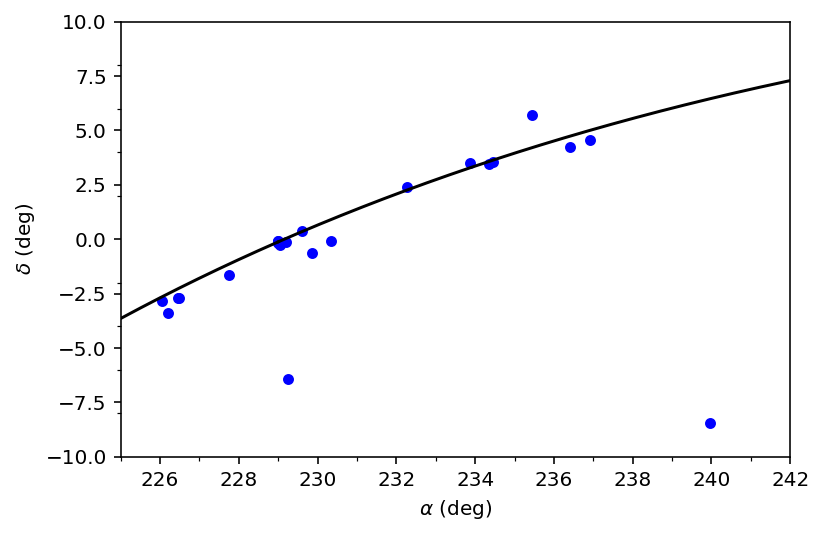

In [8]:
o_fwd.plot(d1='ra', d2='dec', c='k')
o_bkw.plot(d1='ra', d2='dec', c='k', overplot=True)

plt.scatter(data["RA"], data["DE"], s=20, c='blue')
plt.xlim((225, 242))
plt.ylim((-10, 10))
plt.show();

## Orbit Projection

In [9]:
vxvv_sc = SkyCoord(ra=vxvv["RA"], dec=vxvv["DE"],
             distance=vxvv["Dist"]
)

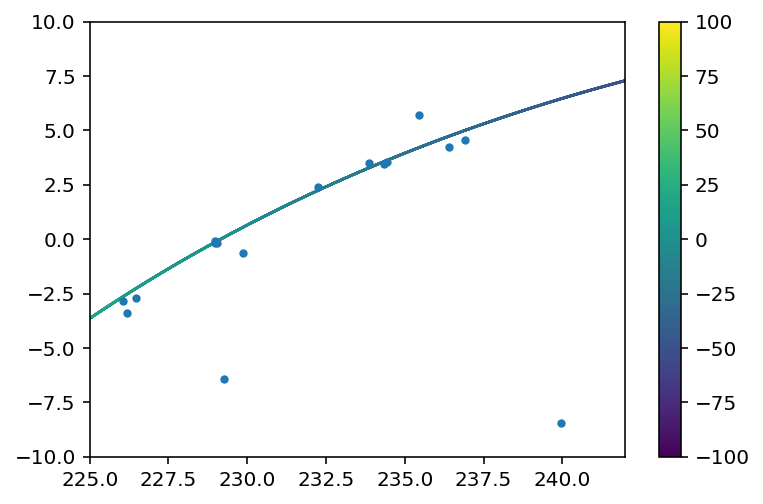

In [10]:
# affine parameter
orbit_time_param = [*t_bkw[::-1], *t_fwd] << u.Myr

# create single catalog
orbit_catalog = coords.concatenate([sc_bkw.frame, sc_fwd.frame])

# plot
line = plt.scatter(orbit_catalog.ra.value, orbit_catalog.dec.value,
                   c=orbit_time_param.value, s=0.1)
plt.scatter(vxvv["RA"], vxvv["DE"], s=10)
plt.colorbar(line)
plt.xlim((225, 242))
plt.ylim((-10, 10))
plt.show();

Construct an orbit reference from from the galpy Orbit.

In [11]:
frame = starkman_thesis.coordinates.OrbitSkyOffsetFrame.from_galpy_orbit(
    orbit=o_fwd, orbit_bkw=o_bkw, frame="icrs", time_unit=u.Myr, method="linear", inverse_track_fn_kw={"tol": 1}
)

frame

<OrbitSkyOffsetICRS Frame (potential=[<galpy.potential.PowerSphericalPotentialwCutoff.PowerSphericalPotentialwCutoff object at 0x11c6bded0>, <galpy.potential.MiyamotoNagaiPotential.MiyamotoNagaiPotential object at 0x11f7d2310>, <galpy.potential.TwoPowerSphericalPotential.NFWPotential object at 0x11fc9cd10>], afn_bound_tail=-100.00000000000001 Myr, afn_bound_lead=100.00000000000001 Myr, origin=<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (229., -0.124, 22.9)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-2.296, -2.257, -58.7)>)>

Transform the coordinates to this reference frame.

In [12]:
new_c = vxvv_sc.transform_to(frame)
new_c

afn_name:  time
afn_name:  None


<SkyCoord (OrbitSkyOffsetICRS: potential=[<galpy.potential.PowerSphericalPotentialwCutoff.PowerSphericalPotentialwCutoff object at 0x11c6bded0>, <galpy.potential.MiyamotoNagaiPotential.MiyamotoNagaiPotential object at 0x11f7d2310>, <galpy.potential.TwoPowerSphericalPotential.NFWPotential object at 0x11fc9cd10>], afn_bound_tail=-100.00000000000001 Myr, afn_bound_lead=100.00000000000001 Myr, origin=<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (229., -0.124, 22.9)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-2.296, -2.257, -58.7)>): (afn, sep, distance, _PA) in (Myr, deg, kpc, rad)
    [(-3.00030003e-02,   0.02612332, 20.73, 5.69665498),
     ( 1.37713771e+01,  -0.63238556, 19.82, 2.3847643 ),
     (-1.21012101e+00,  -0.94203949, 20.86, 2.48084327),
     ( 1.50015002e-01,  -0.04633221, 20.33, 2.517686  ),
     (-5.00050005e-02,  -0.06715071, 20.65, 2.47896878),
     (-2.17121712e+01,  -0.09636559, 21.99, 2.59876473),
     (-1.38113811e+01,

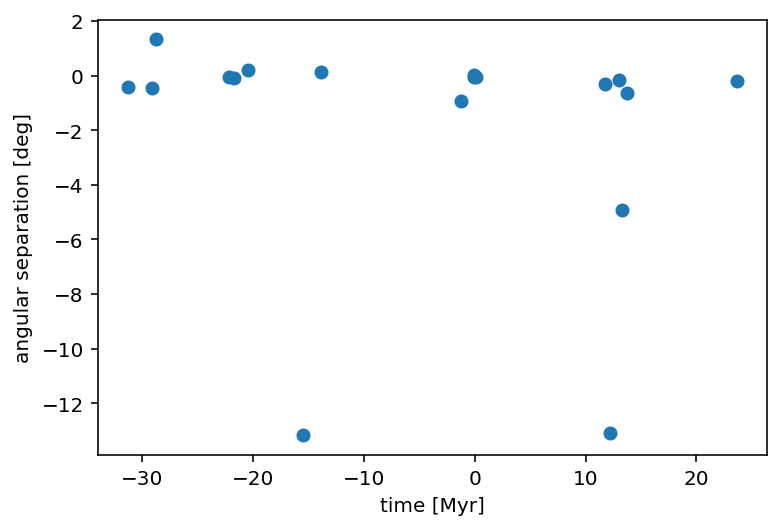

In [14]:
plt.scatter(new_c.afn, new_c.sep)
plt.xlabel(f"time [{new_c.afn.unit}]")
plt.ylabel(f"angular separation [{new_c.sep.unit}]")
plt.show();

And this can be transformed back

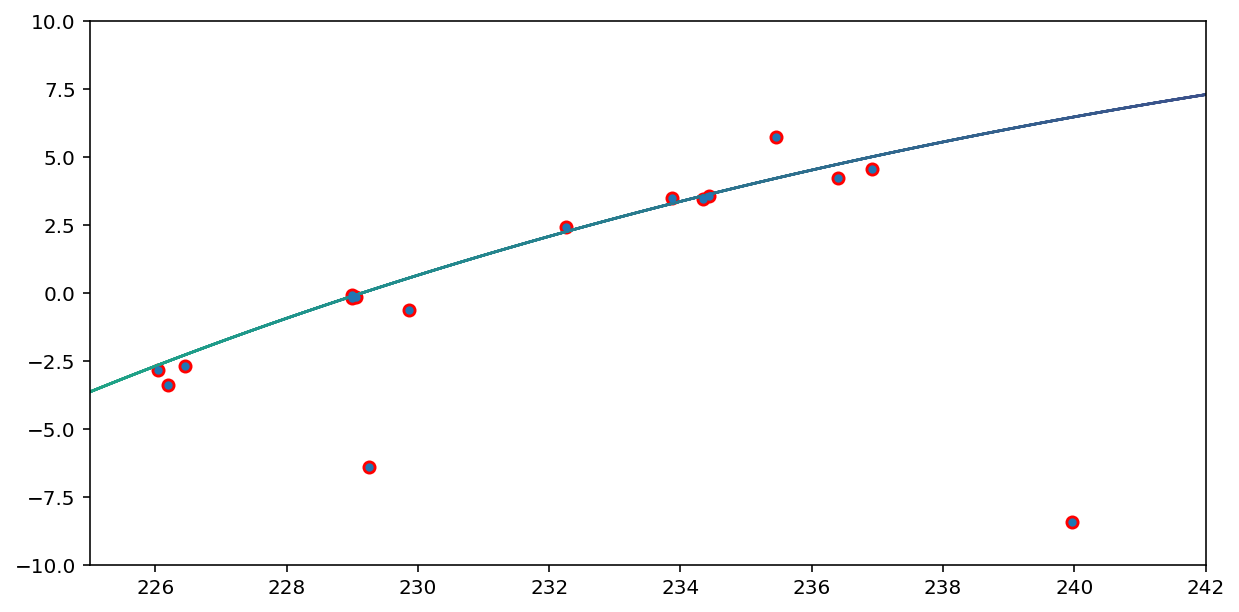

In [15]:
back_c = new_c.transform_to("icrs")

plt.figure(figsize=(10, 5))
plt.scatter(back_c.ra, back_c.dec, c="r")
line = plt.scatter(orbit_catalog.ra.value, orbit_catalog.dec.value,
                   c=orbit_time_param.value, s=0.1)
plt.scatter(vxvv["RA"], vxvv["DE"], s=10)
plt.xlim((225, 242))
plt.ylim((-10, 10))
plt.show();

In [16]:
vxvv_sc
back_c

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(228.99266626,  -0.09659805, 20.73),
     (226.19935059,  -3.37701858, 19.82),
     (229.86585582,  -0.64149219, 20.86),
     (228.99144962,  -0.18985357, 20.33),
     (229.05318547,  -0.16753341, 20.65),
     (234.34615618,   3.45827572, 21.99),
     (232.25954684,   2.40867941, 21.99),
     (226.04797123,  -2.85841498, 19.91),
     (234.44145203,   3.55305196, 21.95),
     (226.45558528,  -2.69837162, 19.36),
     (236.39953342,   4.22287661, 20.87),
     (233.86873164,   3.50153592, 21.82),
     (236.92397529,   4.55354053, 21.97),
     (235.15824385, -12.13022941, 18.61),
     (223.62815625,  -5.34656059, 18.99),
     (235.45320795,   5.72252746, 21.15),
     (239.96251937,  -8.4429523 , 19.82),
     (229.2597106 ,  -6.41903565, 20.31)]>

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(228.99266626,  -0.09659805, 20.73),
     (226.19935059,  -3.37701858, 19.82),
     (229.86585582,  -0.64149219, 20.86),
     (228.99144962,  -0.18985357, 20.33),
     (229.05318547,  -0.16753341, 20.65),
     (234.34615618,   3.45827572, 21.99),
     (232.25954684,   2.40867941, 21.99),
     (226.04797123,  -2.85841498, 19.91),
     (234.44145203,   3.55305196, 21.95),
     (226.45558528,  -2.69837162, 19.36),
     (236.39953342,   4.22287661, 20.87),
     (233.86873164,   3.50153592, 21.82),
     (236.92397529,   4.55354053, 21.97),
     (235.15824385, -12.13022941, 18.61),
     (223.62815625,  -5.34656059, 18.99),
     (235.45320795,   5.72252747, 21.15),
     (239.96251937,  -8.4429523 , 19.82),
     (229.2597106 ,  -6.41903565, 20.31)]>

## Transforming Between OrbitSkyOffsetFrames

it works.

In [17]:
pos2 = pos.vxvv.replicate(copy=True)
pos2.data.x[()] = pos2.data.x + (1 * u.kpc)
pos2.cache.clear()

pos2 = SkyCoord(pos2)

In [18]:
# forward
o2_fwd = Orbit(vxvv=pos2)
t2_fwd = np.linspace(0, 100, num=10000) * u.Myr
o2_fwd.integrate(t=t2_fwd, pot=MWPotential2014)
sc2_fwd = o2_fwd.SkyCoord(t2_fwd)

# backward
o2_bkw = Orbit(vxvv=pos2)
t2_bkw = np.linspace(0, -100, num=10000) * u.Myr
o2_bkw.integrate(t=t2_bkw, pot=MWPotential2014)
sc2_bkw = o2_bkw.SkyCoord(t_bkw[::-1])

/Users/nathanielstarkman/miniconda3/lib/python3.7/site-packages/astropy/coordinates/builtin_frames/galactocentric.py:373: AstropyDeprecationWarning: In v4.1 and later versions, the Galactocentric frame will adopt default parameters that may update with time. An updated default parameter set is already available through the astropy.coordinates.galactocentric_frame_defaults ScienceState object, as described in but the default is currently still set to the pre-v4.0 parameter defaults. The safest way to guard against changing default parameters in the future is to either (1) specify all Galactocentric frame attributes explicitly when using the frame, or (2) set the galactocentric_frame_defaults parameter set name explicitly. See http://docs.astropy.org/en/latest/coordinates/galactocentric.html for more information.
  AstropyDeprecationWarning)



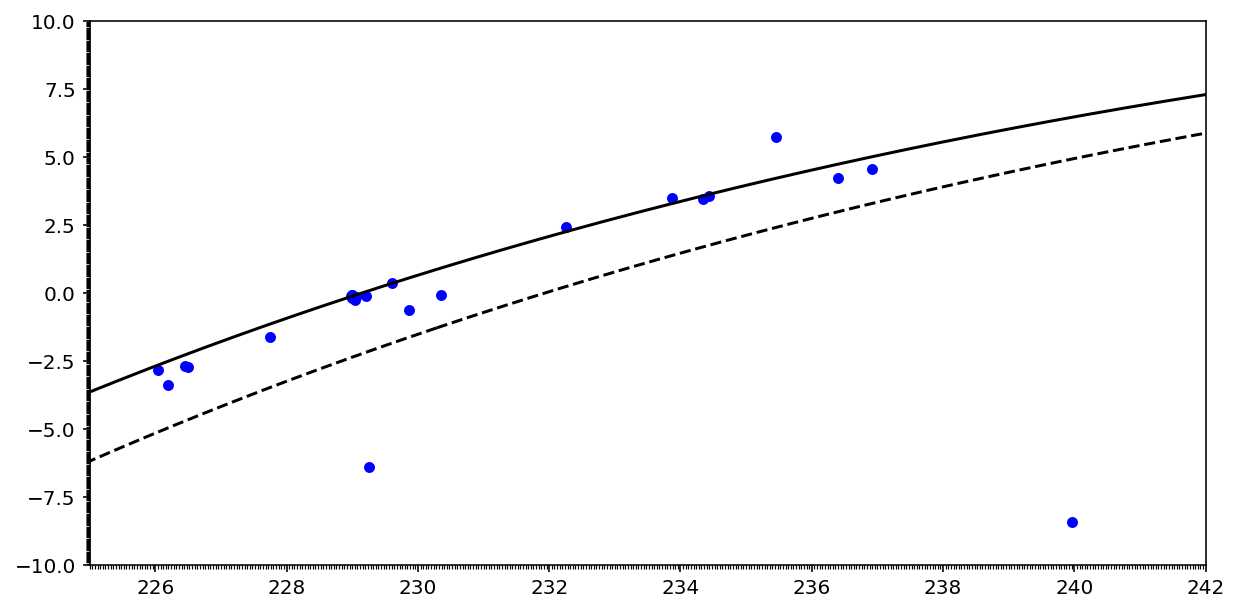

In [19]:
plt.figure(figsize=(10, 5))
o_fwd.plot(d1='ra', d2='dec', c='k', overplot=True)
o_bkw.plot(d1='ra', d2='dec', c='k', overplot=True)

o2_fwd.plot(d1='ra', d2='dec', c='k', ls="--", overplot=True)
o2_bkw.plot(d1='ra', d2='dec', c='k', ls="--", overplot=True)

plt.scatter(data["RA"], data["DE"], s=20, c='blue')
plt.xlim((225, 242))
plt.ylim((-10, 10))
plt.show();

In [20]:
frame2 = starkman_thesis.coordinates.OrbitSkyOffsetFrame.from_galpy_orbit(
    orbit=o2_fwd, orbit_bkw=o2_bkw, frame="icrs", time_unit=u.Myr
)

frame2

<OrbitSkyOffsetICRS Frame (potential=[<galpy.potential.PowerSphericalPotentialwCutoff.PowerSphericalPotentialwCutoff object at 0x11c6bded0>, <galpy.potential.MiyamotoNagaiPotential.MiyamotoNagaiPotential object at 0x11f7d2310>, <galpy.potential.TwoPowerSphericalPotential.NFWPotential object at 0x11fc9cd10>], afn_bound_tail=-100.00000000000001 Myr, afn_bound_lead=100.00000000000001 Myr, origin=<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (230.28641135, -1.29095736, 23.60941426)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-2.21456754, -2.20053269, -59.27722962)>)>

In [21]:
new_c.transform_to(frame)

afn_name:  time
afn_name:  None


<SkyCoord (OrbitSkyOffsetICRS: potential=[<galpy.potential.PowerSphericalPotentialwCutoff.PowerSphericalPotentialwCutoff object at 0x11c6bded0>, <galpy.potential.MiyamotoNagaiPotential.MiyamotoNagaiPotential object at 0x11f7d2310>, <galpy.potential.TwoPowerSphericalPotential.NFWPotential object at 0x11fc9cd10>], afn_bound_tail=-100.00000000000001 Myr, afn_bound_lead=100.00000000000001 Myr, origin=<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (229., -0.124, 22.9)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-2.296, -2.257, -58.7)>): (afn, sep, distance, _PA) in (Myr, deg, kpc, rad)
    [(-3.00030003e-02,   0.02612332, 20.73, 5.69665498),
     ( 1.37713771e+01,  -0.63238556, 19.82, 2.3847643 ),
     (-1.21012101e+00,  -0.94203949, 20.86, 2.48084327),
     ( 1.50015002e-01,  -0.04633221, 20.33, 2.517686  ),
     (-5.00050005e-02,  -0.06715071, 20.65, 2.47896878),
     (-2.17121712e+01,  -0.09636559, 21.99, 2.59876473),
     (-1.38113811e+01,

In [22]:
new_c2 = new_c.transform_to(frame2)
new_c2

afn_name:  time
afn_name:  None


<SkyCoord (OrbitSkyOffsetICRS: potential=[<galpy.potential.PowerSphericalPotentialwCutoff.PowerSphericalPotentialwCutoff object at 0x11c6bded0>, <galpy.potential.MiyamotoNagaiPotential.MiyamotoNagaiPotential object at 0x11f7d2310>, <galpy.potential.TwoPowerSphericalPotential.NFWPotential object at 0x11fc9cd10>], afn_bound_tail=-100.00000000000001 Myr, afn_bound_lead=100.00000000000001 Myr, origin=<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (230.28641135, -1.29095736, 23.60941426)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-2.21456754, -2.20053269, -59.27722962)>): (afn, sep, distance, _PA) in (Myr, deg, kpc, rad)
    [(  0.83008301,   1.7430336 , 20.73, 5.59669113),
     ( 14.60146015,   1.13593026, 19.82, 5.52021384),
     ( -0.280028  ,   0.76936231, 20.86, 5.60218884),
     (  1.03010301,   1.67166506, 20.33, 5.59598461),
     (  0.83008301,   1.64980982, 20.65, 5.59782657),
     (-20.86208621,   1.48223992, 21.99, 5.71637876),
   

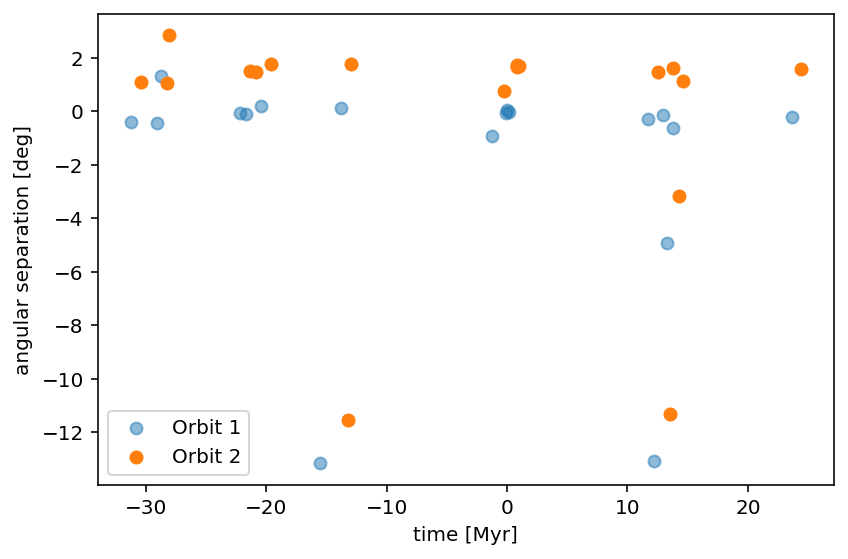

In [23]:
plt.scatter(new_c.afn, new_c.sep, alpha=0.5, label="Orbit 1")
plt.scatter(new_c2.afn, new_c2.sep, label="Orbit 2")
plt.xlabel(f"time [{new_c2.afn.unit}]")
plt.ylabel(f"angular separation [{new_c2.sep.unit}]")

plt.tight_layout()
plt.legend()
plt.show();

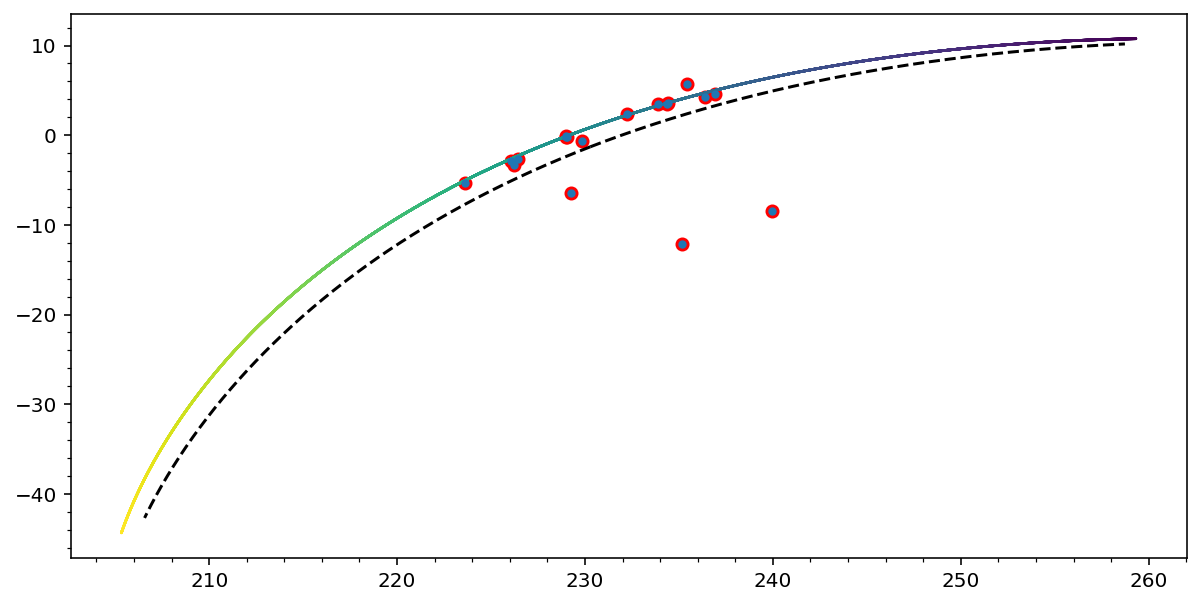

In [24]:
back_c2 = new_c2.transform_to("icrs")

plt.figure(figsize=(10, 5))
plt.scatter(back_c2.ra, back_c2.dec, c="r")
line = plt.scatter(orbit_catalog.ra.value, orbit_catalog.dec.value,
                   c=orbit_time_param.value, s=0.1)
plt.scatter(vxvv["RA"], vxvv["DE"], s=10)

o2_fwd.plot(d1='ra', d2='dec', c='k', ls="--", overplot=True)
o2_bkw.plot(d1='ra', d2='dec', c='k', ls="--", overplot=True)
plt.show();

## Some Details

In [25]:
# Attributes
pa = starkman_thesis.coordinates.attributes.PotentialAttribute()
pa.convert_input(MWPotential2014[0])

(<galpy.potential.PowerSphericalPotentialwCutoff.PowerSphericalPotentialwCutoff at 0x11c6bded0>,
 False)

In [26]:
# representations
rep = starkman_thesis.coordinates.representations.OrbitSkyOffsetRepresentation(
    10*u.Myr, 2*u.deg, coords.Distance(parallax=2*u.mas), afn_name="time"
)
rep

rep.time

afn_name:  time


<OrbitSkyOffsetRepresentation (afn, sep, distance, _PA) in (Myr, deg, pc, deg)
    (10., 2., 500., nan)>

<Quantity 10. Myr>